In [3]:
import pypsa
import pandas as pd
import numpy as np

In [4]:
solver = "cbc"

In this exercise, we will working with `link` component in PyPSA and go through different applications of links. The exercise consists of three main checkpoints:
- Simulating energy flow between two buses with link
- Simulating energy carrier conversion in PyPSA
- Simulating infrastructure with multiple outputs using customised link

*** 
Check-point 1:

**Simulating energy flow between two buses with link**

*Build a network in PyPSA with the two buses North and South and attach the `100MW` electricity load at each bus. North bus is attached with a `gas_power_plant`, while South is attached by a `solar farm` with flexible capacities. All plants' techno-economic parameters are provided. Afterward, use `link` to connect the two buses and observe the power exchange between two bus.* 

#### Initialize network

In [5]:
# Create empty PyPSA network
network = pypsa.Network()
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="H", inclusive="left")
network.set_snapshots(snapshots)
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

Add bus `North` and `South` to the network

In [6]:
network.add(class_name="Bus",
            name="north",
            carrier="Electricity")

network.add(class_name="Bus",
            name="south",
            carrier="Electricity")

Add `200MW` load to each of the bus

In [7]:
# You can madd instead of add to add multiple components at once
network.madd(class_name="Load", names=['north_elec_load', 'south_elec_load'], bus=['north', 'south'], p_set=[200, 200])

Index(['north_elec_load', 'south_elec_load'], dtype='object')

Add power plants to each bus

In [8]:
# We need to calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [9]:
# Gas-fired power plant techno-economic parameters are given as:
lifetime = 25
interest = 0.05
CAPEX = 995257 # $/MW
FOM = 33234 # $/MW fixed
VOM = 5  # $/MWh variable
fuel_cost = 24.57 # $/MWhth - per unit gas consumed
efficiency = 0.57

In [10]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator",
    name="gas_power_plant",
    bus='north',
    marginal_cost=VOM + fuel_cost/efficiency, #$/MWh
    capital_cost= annualized_capex + FOM, #$/MW
    p_nom_extendable = True,  # Allow endogenous investment
    efficiency=efficiency, 
)

In [11]:
# Import an example daily pattern
solar_pattern = pd.read_csv("../data/weather data/example_solar_daily_pattern.csv")["daily pattern"]
# annual time-series availability of solar farm(just a simplified example)
yearly_avail = pd.Series(list(solar_pattern) *365, index=network.snapshots)

In [12]:
# Solar farm techno-economic parameters are given as:
lifetime = 37.5
interest = 0.05
CAPEX = 744227  # $/MW
FOM = 12856.5  # $/MW fixed
VOM = 0.0106  # $/MWh variable
fuel_cost = 0  # per unit of sun consumed

In [13]:
annualized_capex = calculate_annualised_capex(capex=CAPEX, interest=interest, lifetime=lifetime)

network.add(
    class_name="Generator",
    name="solar_farm",
    bus='south',
    marginal_cost=VOM,
    capital_cost=annualized_capex,
    p_nom_extendable=True, # Allow endogenous investment
    p_max_pu=yearly_avail,  # Solar farm availability
)

Add bi-direction links between `North` and `South`

In [14]:
network.add(class_name="Link", 
            name="north_to_south_transmission",
            bus0="north",
            bus1="south",
            p_nom_extendable=True, # allow flexible capacity expansion
            p_min_pu=-1) # to allow bi-directional 

Now try to solve the network and check the results

In [15]:
# Solve network using cbc solver
network.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 101.80it/s]
INFO:linopy.io: Writing time: 0.35s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-u9a59mpe.lp -solve -solu /tmp/linopy-solve-2g3px9ed.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 4015 (-66068) rows, 4016 (-22267) columns and 8030 (-109868) elements
Perturbing problem by 0.001% of 77233.043 - largest nonzero change 0.00078004728 ( 0.018116888%) - largest zero change 0
0  Obj 2.1010081e+08 Dual inf 190808.41 (4015)
155  Obj 1.3584413e+08 Primal inf 2553006.9 (3860)
310  Obj 1.388256e+08 Primal inf 1853727.3 (3705)
465  Obj 1.4180727e+08 Primal inf 1503088.5 (3550)
620  Obj 1.4478905e+08 Primal inf 1344202.2 (3395)
775  Obj 1.4777083e+08 Primal inf 1202379.1 (3240)
930  O

('ok', 'optimal')

In [16]:
# inspect transmission capacity
network.links['p_nom_opt']

Link
north_to_south_transmission    200.0
Name: p_nom_opt, dtype: float64

In [17]:
# inspect power plants' capacities
network.generators["p_nom_opt"]

Generator
gas_power_plant    400.00000
solar_farm         579.75216
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

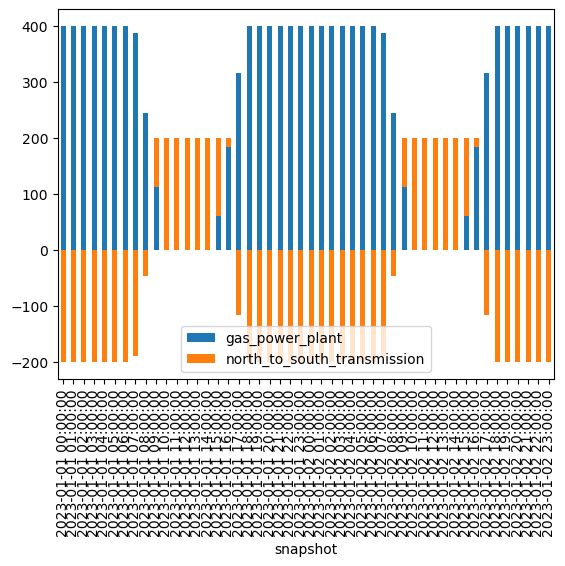

In [18]:
# Inspect transmission flow interaction with other powerplants to supply loads at north bus
north_gen_id = network.generators[network.generators.bus == 'north'].index
north_gen = network.generators_t.p[north_gen_id]
# use p1 to show the electricity flowing out from north
ntc_flow = network.links_t.p1
result = pd.concat([north_gen, ntc_flow], axis=1)
# plot the first 2 days
result.iloc[:48,:].plot(kind='bar', stacked=True)


Exporting check-point 1 network

In [19]:
network.export_to_netcdf("../results/network_d1_e3-1.nc")

INFO:pypsa.io:Exported network network_d1_e3-1.nc has generators, links, buses, loads


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   generators_i: 2, generators_t_p_max_pu_i: 1,
                                   generators_t_p_i: 2, links_i: 1,
                                   links_t_p0_i: 1, links_t_p1_i: 1,
                                   buses_i: 2, buses_t_p_i: 2,
                                   buses_t_marginal_price_i: 2, loads_i: 2,
                                   loads_t_p_i: 2)
Coordinates: (12/13)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * generators_i                  (generators_i) object 16B 'gas_power_plant'...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 8B 'solar_...
  * generators_t_p_i              (generators_t_p_i) object 16B 'gas_power_pl...
  * links_i                       (links_i) object 8B 'north_to_south_transmi...
    ...                            ...
  * links_t_p1_i                  (links_t_p1_i) object 8B 'north_to_south_tr...
  * buses_i                       (buses_i) object 16B 'north' 'south'
  * buses_t_p_i                   (buses_t_p_i) object 16B 'north' 'south'
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 16B 'nort...
  * loads_i                       (loads_i) object 16B 'north_elec_load' 'sou...
  * loads_t_p_i                   (loads_t_p_i) object 16B 'north_elec_load' ...
Data variables: (12/28)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    buses_carrier                 (buses_i) object 16B 'Electricity' 'Electri...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 140kB ...
    loads_bus                     (loads_i) object 16B 'north' 'south'
    loads_p_set                   (loads_i) float64 16B 200.0 200.0
    loads_t_p                     (snapshots, loads_t_p_i) float64 140kB 200....
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           181533762.22523993
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

*** 
Check-point 2:

**Simulating energy carrier conversion in PyPSA**

*In this exercise, we will simulate a gas-fired power plant using the `link` component instead of the `generator`. To set it up, we will create a theoretical gas supply bus (With theoretical gas supply `generator` attached to it) and connect it to an electricity bus with an electrical load through the `link` component* 

#### Initialize network

In [20]:
# Create empty PyPSA network
network = pypsa.Network()
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="H", inclusive="left")
network.set_snapshots(snapshots)
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

Add electricity bus and `100MW` load 

In [21]:
# add electricity bus
network.add(class_name="Bus", name="electricity", carrier='electricity')
# add electricity load
network.add(class_name="Load", bus='electricity', name="electricity_load", p_set=100)

Add theoretical gas bus with a theroretical gas supply `generator` 

In [22]:
# Gas-fired power plant techno-economic parameters are given as:
lifetime = 25
interest = 0.05
CAPEX = 995257 # $/MW
FOM = 33234 # $/MW fixed
VOM = 5  # $/MWh variable
fuel_cost = 24.57 # $/MWhth - per unit gas consumed
efficiency = 0.57

In [23]:
# add gas bus
network.add(class_name="Bus", name="gas_hub", carrier='gas')
# add theoretical gas supply generator
network.add(class_name="Generator",
  name="gas_supply",
  bus="gas_hub",
  carrier="gas",
  marginal_cost=fuel_cost, # Cost per thermal unit gas consumed
  p_nom_extendable=True, # assuming unlimited supply
  )

Add link representing gas-fired power plant converting gas into electricity

In [24]:
annualized_capex = calculate_annualised_capex(capex=CAPEX, interest=interest, lifetime=lifetime)

network.add(class_name="Link",
      name="gas_power_plant",
      bus0="gas_hub",
      bus1="electricity",
      marginal_cost= VOM * efficiency, # All cost input attributes have to be converted from elec to thermal by multiplying efficiency.
      capital_cost= (annualized_capex + FOM) * efficiency,  # All cost input attributes have to be converted from elec to thermal by multiplying efficiency
      # p_nom = 100 / efficiency, # All capacity input attributes have to be converted from elec to thermal by dividing efficiency
      p_nom_extendable=True,
      efficiency=efficiency,
      )

Now try to solve the network and check the results

In [25]:
# Solve network using cbc solver
network.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 148.26it/s]
INFO:linopy.io: Writing time: 0.23s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-87hywgmd.lp -solve -solu /tmp/linopy-solve-bbk2fwvp.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-52562) rows, 0 (-17522) columns and 0 (-78842) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 49896028
After Postsolve, objective 49896028, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 49896027.68 - 0 iterations time 0.042, Presolve 0.04
Total time (CPU seconds):       2.60   (Wallclock seconds):       0.26


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 17522 primals, 52562 duals
Ob

('ok', 'optimal')

In [26]:
# inspect gas plant capacity
network.links['p_nom_opt'].mul(network.links['efficiency']) #converting back from thermal to electricity

Link
gas_power_plant    100.000002
dtype: float64

In [27]:
-network.links_t.p1.round()

Link,gas_power_plant
snapshot,
2023-01-01 00:00:00,100.0
2023-01-01 01:00:00,100.0
2023-01-01 02:00:00,100.0
2023-01-01 03:00:00,100.0
2023-01-01 04:00:00,100.0
...,...
2023-12-31 19:00:00,100.0
2023-12-31 20:00:00,100.0
2023-12-31 21:00:00,100.0


Exporting check-point 2 network

In [28]:
network.export_to_netcdf("../results/network_d1_e3-2.nc")

INFO:pypsa.io:Exported network network_d1_e3-2.nc has generators, links, buses, loads


<xarray.Dataset> Size: 841kB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   generators_i: 1, generators_t_p_i: 1,
                                   links_i: 1, links_t_p0_i: 1,
                                   links_t_p1_i: 1, buses_i: 2, buses_t_p_i: 1,
                                   buses_t_marginal_price_i: 2, loads_i: 1,
                                   loads_t_p_i: 1)
Coordinates:
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * generators_i                  (generators_i) object 8B 'gas_supply'
  * generators_t_p_i              (generators_t_p_i) object 8B 'gas_supply'
  * links_i                       (links_i) object 8B 'gas_power_plant'
  * links_t_p0_i                  (links_t_p0_i) object 8B 'gas_power_plant'
  * links_t_p1_i                  (links_t_p1_i) object 8B 'gas_power_plant'
  * buses_i                       (buses_i) object 16B 'electricity' 'gas_hub'
  * buses_t_p_i                   (buses_t_p_i) object 8B 'electricity'
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 16B 'elec...
  * loads_i                       (loads_i) object 8B 'electricity_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'electricity_load'
Data variables: (12/28)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    buses_carrier                 (buses_i) object 16B 'electricity' 'gas'
    buses_t_p                     (snapshots, buses_t_p_i) float64 70kB 2e-06...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 140kB ...
    loads_bus                     (loads_i) object 8B 'electricity'
    loads_p_set                   (loads_i) float64 8B 100.0
    loads_t_p                     (snapshots, loads_t_p_i) float64 70kB 100.0...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           49896027.67920191
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

*** 
Check-point 3:

**Simulating infrastructure with multiple outputs using customised link**

*A `link` component in PyPSA can be configured to support multiple outputs. In this exercise, we will modify the gas_power_plant from the previous task to simulate and account for its CO2 emission releasing to the atmosphere as a secondary output alongside electricity generation.*

> **Hint:** Links can also be defined with multiple outputs in fixed ratio to the power in the single input by defining new columns bus2, bus3, etc. in network.links along with associated columns for efficiency2, efficiency3, etc. The different outputs are then equal to the input multiplied by the corresponding efficiency. For more information about this, checkout [PyPSA documentation about multi-link](https://pypsa.readthedocs.io/en/latest/user-guide/components.html#multilink)


Import checkpoint point 2 network

In [29]:
network = pypsa.Network("../results/network_d1_e3-2.nc")

INFO:pypsa.io:Imported network network_d1_e3-2.nc has buses, generators, links, loads


In [30]:
network.links

,bus0,bus1,carrier,efficiency,p_nom_extendable,capital_cost,marginal_cost,p_nom_opt,type,build_year,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
gas_power_plant,gas_hub,electricity,gas,0.57,True,44208.157771,2.85,175.4386,,0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


We first need to create an atmosphere bus with a CO2 theoretical storage. When you need a component to store only without discharge, PyPSA `Store` is recommended.

In [31]:
# adding an atmostphere bus
network.add("Bus",
  "co2_atmosphere",
  carrier="co2"
  )

# adding theoretical storage to store co2 released to the atmosphere 
network.add("Store",
  "co2_atmosphere_storage",
  e_nom_extendable=True, # allow infinite co2
  carrier="co2",
  bus="co2_atmosphere"
  )

In [32]:
network.buses

,carrier,v_nom,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
gas_hub,gas,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
co2_atmosphere,co2,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,


In [33]:
network.links

,bus0,bus1,carrier,efficiency,p_nom_extendable,capital_cost,marginal_cost,p_nom_opt,type,build_year,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
gas_power_plant,gas_hub,electricity,gas,0.57,True,44208.157771,2.85,175.4386,,0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


Now we can modify current `gas_power_plant` link to connect it to `co2_atmosphere` with emission factor of `0.2 tCO2/MWhth` 

In [34]:
# add co2_atmosphere as bus2 of gas link
network.links.loc["gas_power_plant", 'bus2'] = 'co2_atmosphere'
# add emission factor of gas power plant as efficiency2
network.links.loc["gas_power_plant", 'efficiency2'] = 0.2  

/tmp/ipykernel_2579/3721289303.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'co2_atmosphere' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  network.links.loc["gas_power_plant", 'bus2'] = 'co2_atmosphere'


In [35]:
network.links

,bus0,bus1,carrier,efficiency,p_nom_extendable,capital_cost,marginal_cost,p_nom_opt,type,build_year,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
gas_power_plant,gas_hub,electricity,gas,0.57,True,44208.157771,2.85,175.4386,,0,...,0,0,1,0,NaN,NaN,1.0,1.0,co2_atmosphere,0.2


Now try to solve the network and check the results

In [36]:
# Solve network using cbc solver
network.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 124.71it/s]
INFO:linopy.io: Writing time: 0.41s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-89dp94_g.lp -solve -solu /tmp/linopy-solve-sne3wgm_.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-87603) rows, 0 (-35043) columns and 0 (-148922) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 49896028
After Postsolve, objective 49896028, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 49896027.68 - 0 iterations time 0.102, Presolve 0.10
Total time (CPU seconds):       2.65   (Wallclock seconds):       0.42


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35043 primals, 87603 duals
O

('ok', 'optimal')

In [37]:
# how much electricity is produced (transfered to bus1=electricity)?
-network.links_t.p1

Link,gas_power_plant
snapshot,
2023-01-01 00:00:00,100.000002
2023-01-01 01:00:00,100.000002
2023-01-01 02:00:00,100.000002
2023-01-01 03:00:00,100.000002
2023-01-01 04:00:00,100.000002
...,...
2023-12-31 19:00:00,100.000002
2023-12-31 20:00:00,100.000002
2023-12-31 21:00:00,100.000002


how much CO2 is emitted into the atmosphere (transferred to bus2=co2_atmosphere)

In [38]:
# Option 1: Using output as energy flow going into bus2
-network.links_t.p2["gas_power_plant"].sum()

307368.4272

In [39]:
# Option 2: Calculating by output of energy flow going out from bus0 * emission factor as efficiency2
(network.links_t.p0["gas_power_plant"]*network.links.loc["gas_power_plant", "efficiency2"]).sum()

307368.4272

In [40]:
# Option 3: Look at the volume of co2 atmosphere storage
network.stores['e_nom_opt']

Store
co2_atmosphere_storage    307368.42
Name: e_nom_opt, dtype: float64